In [1]:
import numpy as np
import rescomp

import matplotlib.pyplot as plt

In [2]:
# best one so far
def get_lypunov_exponents_minimal(data_creation_function, tau, T, N, dt, eps, m, starting_point=None, iteration_process=False):
    
    # setting up
    tau_timesteps = int(tau/dt)
    T_timesteps = int(T/dt)
    
    if tau_timesteps == 0:
        if starting_point is None:
            print("ERROR: starting_point is None, and tau is 0")
            return
        initial_condition = starting_point
    else:     
        initial_condition = data_creation_function(tau_timesteps, dt, starting_point=starting_point)[-1] # discard transient states
    state_dim = initial_condition.size
    if m>state_dim:
        print("ERROR: m > state_dim")
        return
    
    # choose initial orthogonal directions:
    Q = np.eye(state_dim, m)
    
    # Space to save u_js:
    U = np.zeros((state_dim, N+1))
    U[:, 0] = initial_condition
    
    PsiQ = np.zeros(Q.shape)
    
    R_diags = np.zeros((N, m))
    
    for j in range(1, N+1): # for all time intervals
        u_jm1 = U[:, j-1]
        u_j = data_creation_function(T_timesteps, dt, starting_point = u_jm1)[-1]
        U[:, j] = u_j
        for i in range(m): # for all dimensions
            q_i = Q[:, i] # the (j-1)th Q
            u_jm1_per = u_jm1 + eps*q_i
            w_i_j = data_creation_function(T_timesteps, dt, starting_point = u_jm1_per)[-1]
            PsiQ[:, i] = (w_i_j - u_j)/eps # approximation of Psi(t_j, t_jm1)q_i(j_m1)
        
        Q, R = np.linalg.qr(PsiQ) # the new Q (the jth)

        for i in range(m):
            R_diags[j-1, i] = R[i, i]
    lyapunov_exp = np.sum(np.log(np.abs(R_diags))/(N*T), axis = 0)
    if iteration_process:
        times = np.arange(1, N+1)*T
        lyapunov_exp_convergence = np.cumsum(np.log(np.abs(R_diags)), axis = 0)/(np.tile(times, (m, 1)).T)
        return lyapunov_exp, lyapunov_exp_convergence
    return lyapunov_exp

In [3]:
# KS system:
dimensions = 64
system_size = 35
def data_creation_function_KS(time_steps, dt, starting_point=None):
    sim_data = rescomp.simulate_trajectory(
            sys_flag='kuramoto_sivashinsky', dimensions=dimensions, system_size=system_size, dt=dt,
            time_steps=time_steps, starting_point = starting_point)
    return sim_data

# Lorenz system
def data_creation_function_Lorenz(time_steps, dt, starting_point=None):
    return  rescomp.simulate_trajectory(
            sys_flag='lorenz', dt=dt, time_steps=time_steps,
            starting_point=starting_point)

### parameters

In [14]:
starting_point = np.array([-14.03020521, -20.88693127, 25.53545])

dt = 0.1
N = 1000
tau = 100
T = 2
eps = 1e-6

 ### rescomp code:

In [15]:
f = lambda x: data_creation_function_Lorenz(time_steps=2, dt=dt, starting_point=x)[-1]


lyapunov_exp, lyapunov_exp_convergence = rescomp.measures.iterator_based_lyapunov_spectrum(f, starting_point, T=T, 
                                                                                           tau=tau,
                                                  eps=eps, nr_steps=N, dt=dt, return_convergence=True)

[ 0.78373637  0.01584379 -7.98745727]


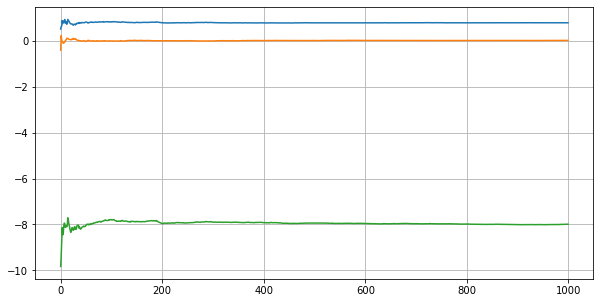

In [16]:
print(lyapunov_exp)
plt.figure(figsize=(10,5))
for iteration in lyapunov_exp_convergence.T:
    plt.plot(iteration)
plt.grid()

### code from notebook

In [10]:
m = 2
lyapunov_exp, lyapunov_exp_convergence = get_lypunov_exponents_minimal(data_creation_function_Lorenz, tau=tau, T=T,
                                              N=N, dt=dt, eps=eps, m=m, starting_point=starting_point,
                                              iteration_process=True)

[ 0.81739352 -0.00483535]


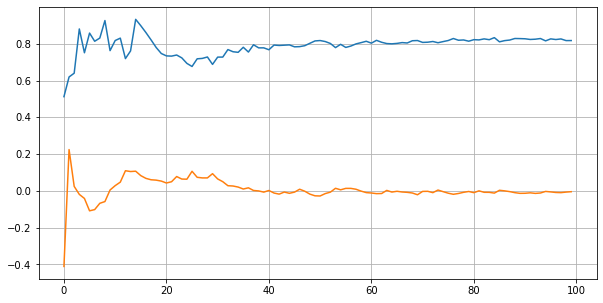

In [11]:
print(lyapunov_exp)
plt.figure(figsize=(10,5))
for iteration in lyapunov_exp_convergence.T:
    plt.plot(iteration)
plt.grid()

In [9]:
data_creation_function_Lorenz(time_steps=4, dt=0.1, starting_point=starting_point)[0] == starting_point

array([ True,  True,  True])